In [209]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pytrends.request import TrendReq

%matplotlib inline

In [2]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Check TensorFlow

In [3]:
print(tf.__version__)

2.3.0


### Get VTI history

In [4]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

In [5]:
vti_close_hist = vti_hist.Close

In [6]:
# this is a good reminder of what day you pulled the history!!!!
vti_close_hist.tail()

Date
2020-08-07    169.80
2020-08-10    170.27
2020-08-11    168.90
2020-08-12    171.16
2020-08-13    171.03
Name: Close, dtype: float64

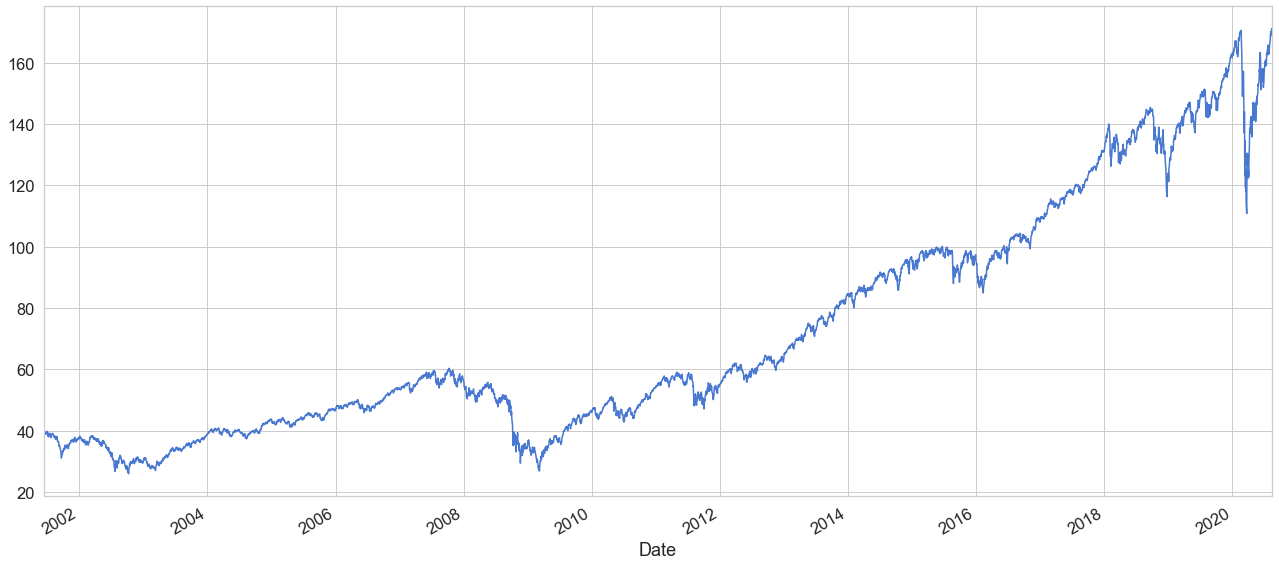

In [7]:
vti_close_hist.plot()

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [8]:
microsoft = yf.Ticker('MSFT').history(period="max")
apple = yf.Ticker('AAPL').history(period="max")
amazon = yf.Ticker('AMZN').history(period="max")
facebook = yf.Ticker('FB').history(period="max")
alphabetA = yf.Ticker('GOOGL').history(period="max")
alphabetC = yf.Ticker('GOOG').history(period="max")
johnson = yf.Ticker('JNJ').history(period="max")
berkshire = yf.Ticker('BRK-B').history(period="max")
visa = yf.Ticker('V').history(period="max")
proctor = yf.Ticker('PG').history(period="max")

In [9]:
# In cases of dividends being reported, during that day the day is listed twice causing a duplicate index.
# droping nan's should get rid of of the duplicate row
holdings = [microsoft, apple, amazon, facebook, alphabetA, alphabetC, johnson, berkshire, visa, proctor]
for holding in holdings:
    holding.dropna(inplace=True)

#### Get DOW

In [10]:
dow = yf.Ticker('DJIA').history(period="max")

#### Get Gooogle Trends data

In [11]:
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(['vti'], timeframe='all')
trend_df = pytrends.interest_over_time()

#### Upsample Google trend data to daily

In [12]:
# upsample: every day in month will have the monthly average
g_trends_daily = trend_df.resample('D').ffill()

In [13]:
last_full_month_value = g_trends_daily.iloc[-2].vti

In [14]:
g_trends_daily.rename(columns={'vti': 'avg_searches', 'date': 'Date'}, inplace=True)

In [15]:
g_trends_daily.drop(columns='isPartial', inplace=True)

In [16]:
g_trends_daily

,avg_searches
date,
2004-01-01,52
2004-01-02,52
2004-01-03,52
2004-01-04,52
2004-01-05,52
...,...
2020-07-28,60
2020-07-29,60
2020-07-30,60


#### Combine holdings into DF

In [17]:
df = pd.concat([vti_hist.Close.rename('vti'),
                 microsoft.Close.rename('msft'),
                 apple.Close.rename('appl'),
                 amazon.Close.rename('amzn'),
                 facebook.Close.rename('fb'),
                 alphabetA.Close.rename('google'),
                 alphabetC.Close.rename('googlb'),
                 johnson.Close.rename('jnj'),
                 berkshire.Close.rename('brk'),
                 visa.Close.rename('visa'),
                 proctor.Close.rename('pg'),
                 dow.Close.rename('dow')], join='outer', axis=1)


#### left join google trends (to accomodate for gtrends including weekends)

In [18]:
df = df.join(g_trends_daily['avg_searches'].rename('gtrnd'), how='left')

#### truncate to dates when vti is in existance

In [19]:
df = df.loc['2001-06-15':]

#### Special Cleaning for Google Trends

In [20]:
# fill the month of august with the values from the last full month
df.gtrnd.iloc[-30::].fillna(last_full_month_value, inplace=True)

In [21]:
df.tail(10)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2020-07-31,165.52,205.01,424.28,3164.68,253.67,1487.95,1482.96,145.76,195.78,190.11,131.12,26428.32,60.0
2020-08-03,166.96,216.54,434.97,3111.89,251.96,1482.76,1474.45,147.35,199.26,190.40,131.29,26664.40,60.0
2020-08-04,167.62,213.29,437.87,3138.83,249.83,1473.30,1464.97,147.22,200.24,192.00,133.79,26828.47,60.0
2020-08-05,168.84,212.94,439.46,3205.03,249.12,1479.09,1473.61,148.40,203.62,195.80,133.44,27201.52,60.0
2020-08-06,169.66,216.35,454.79,3225.00,265.28,1504.95,1500.10,147.55,205.02,198.47,132.71,27386.98,60.0
2020-08-07,169.80,212.48,444.45,3167.46,268.44,1498.37,1494.49,148.60,209.48,196.06,133.55,27433.48,60.0
2020-08-10,170.27,208.25,450.91,3148.16,263.00,1496.82,1496.10,148.03,212.58,196.49,134.10,27791.44,60.0
2020-08-11,168.90,203.38,437.50,3080.67,256.13,1480.54,1480.32,146.97,212.66,197.47,133.23,27686.91,60.0
2020-08-12,171.16,209.19,452.04,3162.24,259.89,1507.24,1506.62,149.66,213.24,198.44,135.46,27976.84,60.0


In [22]:
df.gtrnd.fillna(df.gtrnd.mean(), inplace=True)

### For holdings that didn't exist yet, fill NAs with its minimum price

In [23]:
for col in df.columns:
    df[col].fillna(df[col].min(), inplace=True)

## Modeling

#### Train Test Split

In [24]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

4338 483


In [227]:
train_size

4338

In [231]:
df.iloc[4337]

vti       1.997893
msft      5.129156
appl      2.475306
amzn      6.541874
fb        2.978785
google    2.289399
googlb    2.328954
jnj       2.005785
brk       1.999632
visa      3.089465
pg        1.093089
dow       2.278568
gtrnd     0.250000
Name: 2018-09-12 00:00:00, dtype: float64

In [25]:
# select only feature columns
f_columns = df.columns.drop('vti')

# scale all data
f_transformer = RobustScaler()
vti_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
vti_transformer = vti_transformer.fit(train[['vti']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['vti'] = vti_transformer.transform(train[['vti']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['vti'] = vti_transformer.transform(test[['vti']])

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [26]:
train.head(1)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2001-06-15,-0.324165,-0.004707,-0.31711,-0.38685,0.0,-0.55798,-0.569673,-0.340024,-0.51544,-0.164955,-0.94388,-0.249747,0.1429


In [27]:
#timeseries version of train test split
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [290]:
time_steps = 1

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.vti, time_steps)
X_test, y_test = create_dataset(test, test.vti, time_steps)

print(X_train.shape, y_train.shape)

(4337, 1, 13) (4337,)


In [291]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [292]:
history = model.fit(
    X_train, y_train, 
    epochs=7, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/7
122/122 [==============================] - 1s 7ms/step - loss: 0.0277 - val_loss: 0.0906
Epoch 2/7
122/122 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0275
Epoch 3/7
122/122 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0297
Epoch 4/7
122/122 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0382
Epoch 5/7
122/122 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0419
Epoch 6/7
122/122 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0426
Epoch 7/7
122/122 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0435


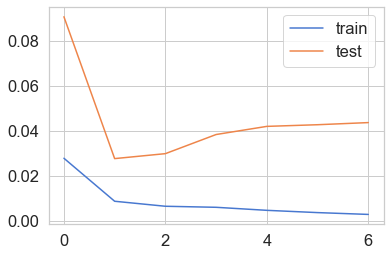

In [293]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [294]:
y_pred = model.predict(X_test)

In [295]:
y_train_inv = vti_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = vti_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = vti_transformer.inverse_transform(y_pred)

In [296]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten()[1:], y_pred_inv.flatten()[:-1])))
print("MAE = ", mean_absolute_error(y_test_inv.flatten()[1:], y_pred_inv.flatten()[:-1]))

RMSE =  23.65790630475967
MAE =  21.638805857319348


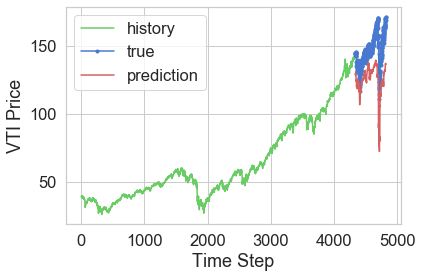

In [297]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/hist_preds.png')
plt.show();

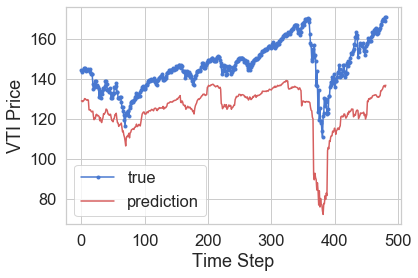

In [298]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/lstm_preds_vs_true.png')
plt.show();


In [299]:
def get_buy_sell(prices):
    outcomes=[]
    for index, price in enumerate(prices[1:]):
        if price > prices[index] :
            outcomes.append(1)
        else:
            outcomes.append(0)
    return outcomes

In [300]:
y_test_outcomes = get_buy_sell(y_test_inv.flatten())

In [301]:
y_pred_outcomes = get_buy_sell(y_pred_inv.flatten())

In [302]:
confusion_matrix(y_test_outcomes, y_pred_outcomes)

array([[ 90, 121],
       [124, 146]])